датасет https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/data

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
import glob
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
import torchvision
from torchvision import transforms as T
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision.models import mobilenet_v2
from torchvision.models import mobilenet_v3_small
from torchvision.models import efficientnet_v2_s
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp /gdrive/'MyDrive'/'Дипломная работа'/paintings.zip .

In [ ]:
!unzip paintings.zip

In [ ]:
path = '/content/images/images'

🟡 EDA - Разведочный анализ данных

In [ ]:
data = pd.read_csv('artists.csv')
data.sample(3)

,id,name,years,genre,nationality,bio,wikipedia,paintings
44,44,Joan Miro,1893 – 1983,Surrealism,Spanish,Joan Miró i Ferrà (; Catalan: [ʒuˈam miˈɾo j f...,https://en.wikipedia.org/wiki/Joan_Miró,102
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
27,27,Diego Velazquez,1599 - 1660,Baroque,Spanish,Diego Rodríguez de Silva y Velázquez (Spanish:...,http://en.wikipedia.org/wiki/Diego_Velázquez,128


🟡 5 картин случайных художников

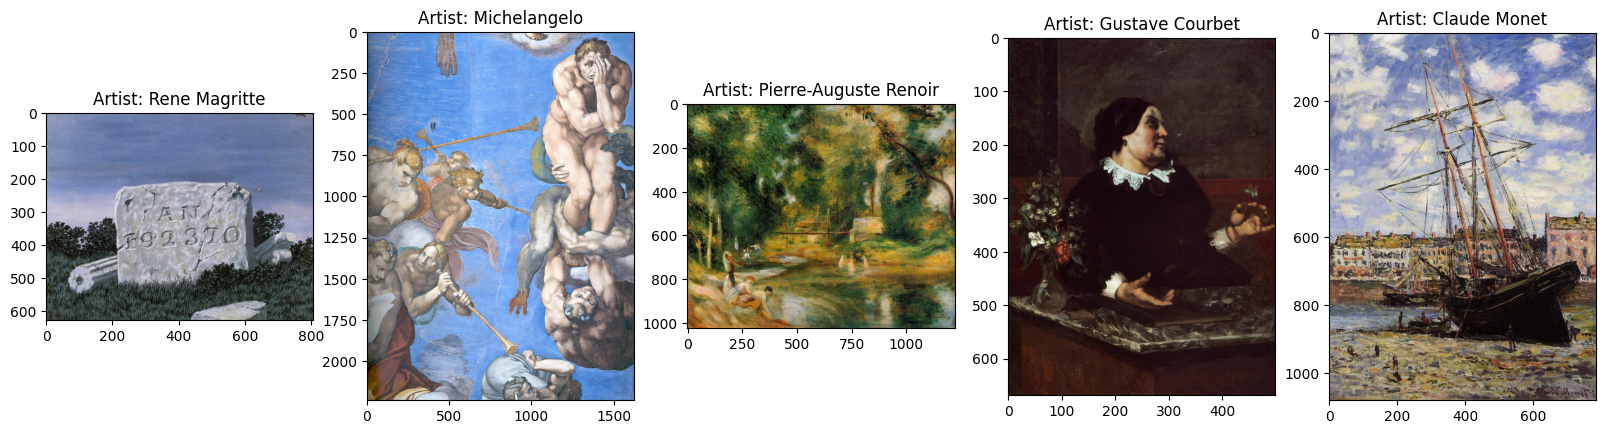

In [ ]:
number = 5
fig, axes = plt.subplots(1, number, figsize=(20,10))

for i in range(number):
    artist = random.choice(data['name'].str.replace(' ', '_').values)
    image = random.choice(os.listdir(os.path.join(path, artist)))
    images = os.path.join(path, artist, image)
    img = plt.imread(images)
    axes[i].imshow(img)
    axes[i].set_title('Artist: ' + artist.replace('_', ' '))

plt.show()

In [ ]:
sum(data.paintings), len(data.name)

(8446, 50)

In [ ]:
data.isna().sum()

id             0
name           0
years          0
genre          0
nationality    0
bio            0
wikipedia      0
paintings      0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           50 non-null     int64 
 1   name         50 non-null     object
 2   years        50 non-null     object
 3   genre        50 non-null     object
 4   nationality  50 non-null     object
 5   bio          50 non-null     object
 6   wikipedia    50 non-null     object
 7   paintings    50 non-null     int64 
dtypes: int64(2), object(6)
memory usage: 3.2+ KB


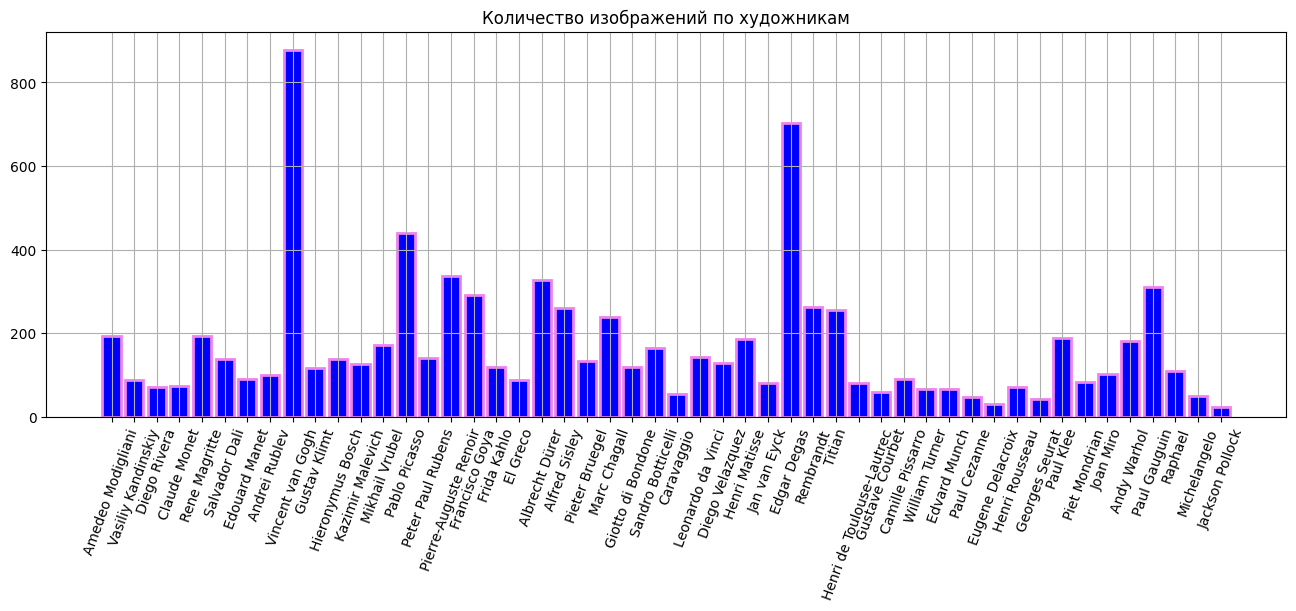

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(data.name, data.paintings, color='blue', edgecolor='violet', linewidth=2)
plt.title('Количество изображений по художникам')
plt.xticks(rotation=70)
plt.grid()
plt.show()

In [ ]:
print(data[['name', 'paintings']].sort_values(by=['paintings'], ascending=False))

                         name  paintings
8            Vincent van Gogh        877
30                Edgar Degas        702
13              Pablo Picasso        439
15      Pierre-Auguste Renoir        336
19             Albrecht Dürer        328
46               Paul Gauguin        311
16             Francisco Goya        291
31                  Rembrandt        262
20              Alfred Sisley        259
32                     Titian        255
22               Marc Chagall        239
4               Rene Magritte        194
0           Amedeo Modigliani        193
42                  Paul Klee        188
28              Henri Matisse        186
45                Andy Warhol        181
12             Mikhail Vrubel        171
24          Sandro Botticelli        164
26          Leonardo da Vinci        143
14          Peter Paul Rubens        141
5               Salvador Dali        139
10           Hieronymus Bosch        137
21             Pieter Bruegel        134
27            Di

🟡 Разделение изображений на train выборку и test в соотношении 80 и 20 для каждого класса с пропорцией классов

In [ ]:
image_paths = glob.glob(f"{path}/*/*.jpg")
image_labels = [paths.split('/')[-2] for paths in image_paths]
train, test = train_test_split(image_paths, test_size=0.2, stratify=image_labels, random_state=7)

print(f"Количество изображений для обучения: {len(train):,}\nКоличество изображений для теста: {len(test):,}")

Количество изображений для обучения: 6,756
Количество изображений для теста: 1,690


🟡 Обучение будет происходить с аугментацией и без. К тестовой выборке аугментация не применяется, так как нужны реальные данные (изображения)

In [ ]:
class parameters:
  input_size = 224
  batch_size = 20
  learning_rate = 1e-4

In [ ]:
train_transform_aug = T.Compose([T.Resize(parameters.input_size),
                                T.CenterCrop(parameters.input_size),
                                T.RandomHorizontalFlip(0.3),
                                T.RandomVerticalFlip(0.3),
                                T.RandomPerspective(distortion_scale = 0.3, p=0.2),
                                T.ToTensor(),
                                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_transform = T.Compose([T.Resize(parameters.input_size),
                             T.CenterCrop(parameters.input_size),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = T.Compose([T.Resize(parameters.input_size),
                            T.CenterCrop(parameters.input_size),
                            T.ToTensor(),
                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
train_dataset_aug = torchvision.datasets.ImageFolder(path, transform = train_transform_aug, is_valid_file = lambda x: x in train)
train_dataset = torchvision.datasets.ImageFolder(path, transform = train_transform, is_valid_file = lambda x: x in train)
test_dataset = torchvision.datasets.ImageFolder(path, transform = test_transform, is_valid_file=lambda x: x in test)

In [ ]:
train_dataset_aug[0][0].shape, test_dataset[0][0].shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [ ]:
print(f"Количество классов в выборке train: {len(train_dataset_aug.classes)}")
print(f"Количество классов в выборке train без аугментации: {len(train_dataset.classes)}")
print(f"Количество классов в выборке test: {len(test_dataset.classes)}")

Количество классов в выборке train: 50
Количество классов в выборке train без аугментации: 50
Количество классов в выборке test: 50


🟡 проверка применения аугментации к изображениям

In [ ]:
def show_images(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(20,10))

    for fig_ in axes.flatten():
        idx = np.random.randint(low=0, high=6500)
        img, label = dataset[idx]
        fig_.set_title(dataset.classes[label])
        fig_.imshow(img.numpy().transpose((1, 2, 0)))

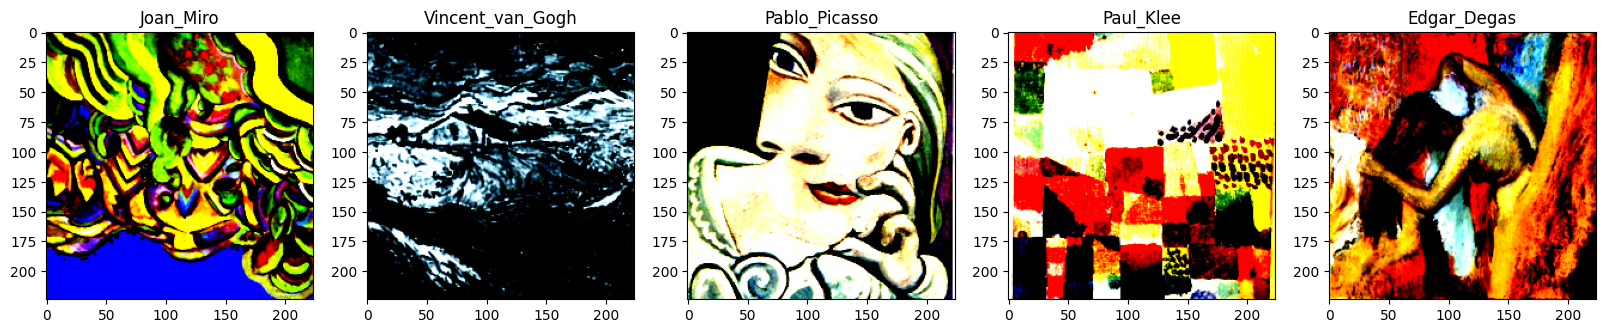

In [ ]:
show_images(train_dataset_aug)

🟡 нужно посчитать веса, чтобы выровнить количество семплов: чем меньше семплов в классе, тем больше вес в WeightedRandomSampler.

In [ ]:
class_count_aug = Counter(train_dataset_aug.targets)
class_weights_aug = {i: 1/c for i, c in class_count_aug.items()}
sample_weights_aug = [0] * len(train_dataset_aug)
for i, (data, label) in enumerate(tqdm(train_dataset_aug)):
    class_weight_aug = class_weights_aug[label]
    sample_weights_aug[i] = class_weight_aug

N_aug = max(class_count_aug.values()) * len(class_count_aug)
train_sampler_aug = WeightedRandomSampler(sample_weights_aug, num_samples=N_aug, replacement=True)

  0%|          | 0/6756 [00:00<?, ?it/s]

In [ ]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

  0%|          | 0/6756 [00:00<?, ?it/s]

In [ ]:
batched_train_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=parameters.batch_size, sampler=train_sampler_aug,
                                            num_workers=8, pin_memory=True)
batched_train = torch.utils.data.DataLoader(train_dataset, batch_size=parameters.batch_size, sampler=train_sampler, num_workers=8,
                                            pin_memory=True)
batched_test = torch.utils.data.DataLoader(test_dataset, batch_size=parameters.batch_size, num_workers=8, pin_memory=True)

🟡 проверка нового распределения, все классы одинаково представлены.

In [ ]:
count_aug = Counter()
for data, labels in tqdm(batched_train_aug):
    count_aug += Counter(labels.tolist())
print(sum(count_aug.values()), count_aug)

  0%|          | 0/1753 [00:00<?, ?it/s]

35050 Counter({16: 760, 24: 749, 37: 735, 8: 733, 4: 732, 26: 730, 15: 730, 9: 729, 34: 726, 43: 725, 30: 725, 39: 725, 45: 724, 36: 723, 28: 722, 19: 714, 12: 714, 22: 714, 47: 712, 11: 712, 33: 711, 5: 710, 14: 703, 0: 702, 1: 702, 3: 701, 31: 700, 35: 700, 48: 699, 21: 695, 38: 695, 42: 692, 44: 690, 40: 688, 49: 687, 25: 686, 13: 684, 7: 684, 20: 681, 41: 681, 27: 678, 32: 672, 46: 668, 18: 665, 29: 664, 17: 663, 23: 662, 10: 653, 2: 652, 6: 648})


In [ ]:
count = Counter()
for data, labels in tqdm(batched_train):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

  0%|          | 0/1753 [00:00<?, ?it/s]

35050 Counter({24: 755, 22: 751, 30: 747, 18: 737, 39: 736, 42: 734, 37: 730, 0: 729, 20: 729, 43: 729, 11: 728, 16: 720, 3: 718, 46: 717, 9: 714, 6: 714, 36: 713, 28: 713, 21: 710, 31: 705, 23: 703, 41: 703, 4: 701, 15: 699, 27: 698, 12: 698, 26: 697, 38: 696, 44: 695, 33: 694, 48: 694, 32: 690, 49: 690, 7: 689, 14: 689, 13: 688, 29: 685, 25: 685, 40: 683, 8: 681, 1: 680, 10: 677, 17: 671, 19: 669, 5: 667, 2: 667, 47: 662, 35: 661, 34: 658, 45: 651})


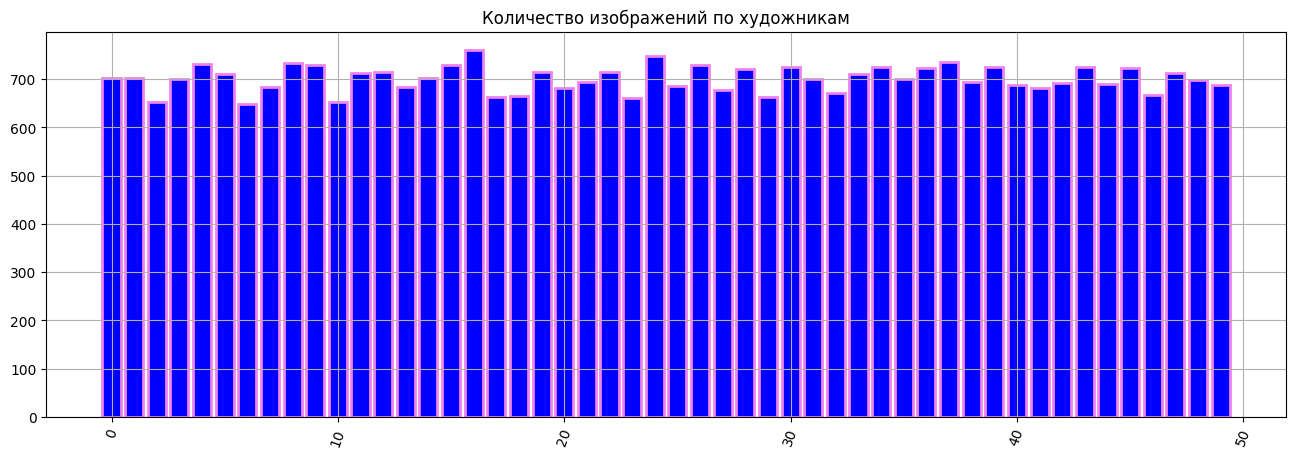

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(count_aug.keys(), count_aug.values(), color='blue', edgecolor='violet', linewidth=2)
plt.title('Количество изображений по художникам')
plt.xticks(rotation=70)
plt.grid()
plt.show()

🟡 функция для визуального отображения loss (потеря) и accuracy (точность)

In [ ]:
def plot_learning(history):
  fig = plt.figure(figsize=(11,5))

  plt.subplot(1,2,1)
  plt.plot(history['loss']['train'], '-*', color='brown', label='Train')
  plt.plot(history['loss']['test'], '-o', color='orange', label='Test')
  plt.title('Training and testing loss', fontsize=11)
  plt.ylabel('Loss', fontsize=9)
  plt.xlabel('Epoch', fontsize=9)
  plt.legend(loc='best')

  plt.subplot(1,2,2)
  plt.plot(history['accuracy']['train'], '-*', color='brown', label='Train')
  plt.plot(history['accuracy']['test'], '-o', color='orange', label='Test')
  plt.title('Training and testing accuracy', fontsize=11)
  plt.ylabel('Accuracy', fontsize=9)
  plt.xlabel('Epoch', fontsize=9)
  plt.legend(loc='best')
  plt.show()

🟡 Функция для обучения модели и вывода значения потери и метрики во время обучения

In [ ]:
def train(model, train_batch, test_batch, num_epochs=20):
  history = defaultdict(lambda: defaultdict(list))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=parameters.learning_rate)

  for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    start_time = time.time()

    model.train()
    for x, y in train_batch:
      x, y = x.to(device), y.long().to(device)
      logits = model(x)
      loss = criterion(logits, y)
      #loss.requires_grad = True
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += np.sum(loss.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      train_acc += np.mean(y.cpu().numpy() == y_pred)

    train_loss /= len(train_batch)
    train_acc /= len(train_batch)
    history['loss']['train'].append(train_loss)
    history['accuracy']['train'].append(train_acc)

    model.eval()
    for x_test, y_test in test_batch:
      x_test, y_test = x_test.to(device), y_test.long().to(device)
      logit = model(x_test)
      loss = criterion(logit, y_test)

      test_loss += np.sum(loss.detach().cpu().numpy())
      y_pred_test = logit.max(1)[1].detach().cpu().numpy()
      test_acc += np.mean(y_test.cpu().numpy() == y_pred_test)

    test_loss /= len(test_batch)
    test_acc /= len(test_batch)
    history['loss']['test'].append(test_loss)
    history['accuracy']['test'].append(test_acc)

    clear_output()

    print(f"Epoch {epoch + 1} of {num_epochs} took {round(time.time() - start_time)} sec")
    print(f"  training loss (in-iteration): \t{train_loss:.3f}")
    print(f"  test loss (in-iteration): \t\t{test_loss:.3f}")
    print(f"  training accuracy: \t\t\t{train_acc * 100:.2f}%")
    print(f"  test accuracy: \t\t\t{test_acc * 100:.2f}%")
    print(classification_report(y_test.cpu().numpy(), y_pred_test))

  plot_learning(history)

  return model, history

🟡 обучение модели mobilenet_v2, вариант - features extraction, на данных без изменений (только уменьшение размерности изображений для быстроты обучение)

In [ ]:
mobilenet_model = mobilenet_v2(weights='IMAGENET1K_V1')
mobilenet_model = mobilenet_model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 92.3MB/s]


In [ ]:
summary(mobilenet_model, (3,224,224))

In [ ]:
for param in mobilenet_model.parameters():
    param.requires_grad = False

mobilenet_model.fc = nn.Linear(1280, 50)

Epoch 20 of 20 took 467 sec
  training loss (in-iteration): 	11.392
  test loss (in-iteration): 		11.602
  training accuracy: 			0.12%
  test accuracy: 			0.06%


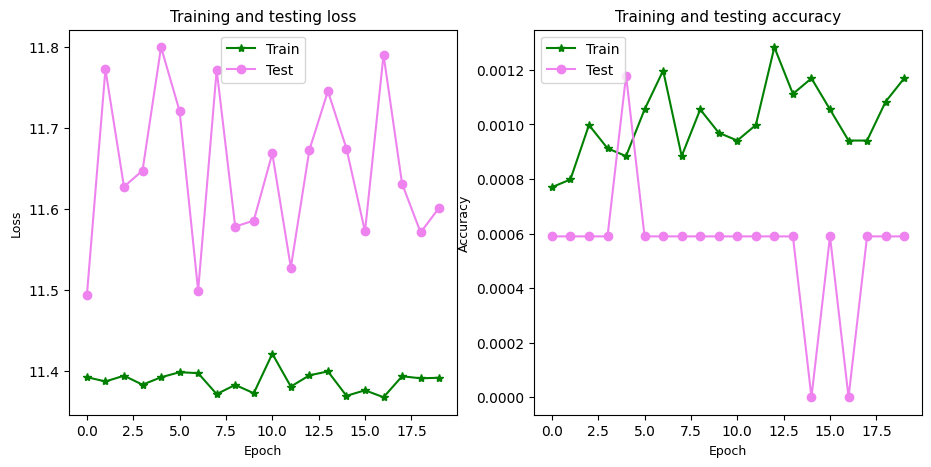

In [ ]:
model_v2, history = train(mobilenet_model, batched_train, batched_test)

🟡 Результат обучения на предварительно обученной модели (features extraction) оказался ужасным: модель не обучилась.  Я не буду использовать этот вариант обучения дальше, чтобы не тратить ресурсы ни временные, ни технические.

In [ ]:
mobilenet_model_ft = nn.Sequential()
mobilenet_model_ft.add_module('mobilenet', mobilenet_v2(weights='IMAGENET1K_V1'))

mobilenet_model_ft.add_module('relu_1', nn.ReLU())
mobilenet_model_ft.add_module('fc_1', nn.Linear(1000, 1280))
mobilenet_model_ft.add_module('relu_2', nn.ReLU())
mobilenet_model_ft.add_module('fc_2', nn.Linear(1280, 50))

mobilenet_model_ft = mobilenet_model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 91.7MB/s]


In [ ]:
summary(mobilenet_model_ft, (3,224,224))

Epoch 20 of 20 took 547 sec
  training loss (in-iteration): 	0.055
  test loss (in-iteration): 		1.329
  training accuracy: 			98.32%
  test accuracy: 			78.12%


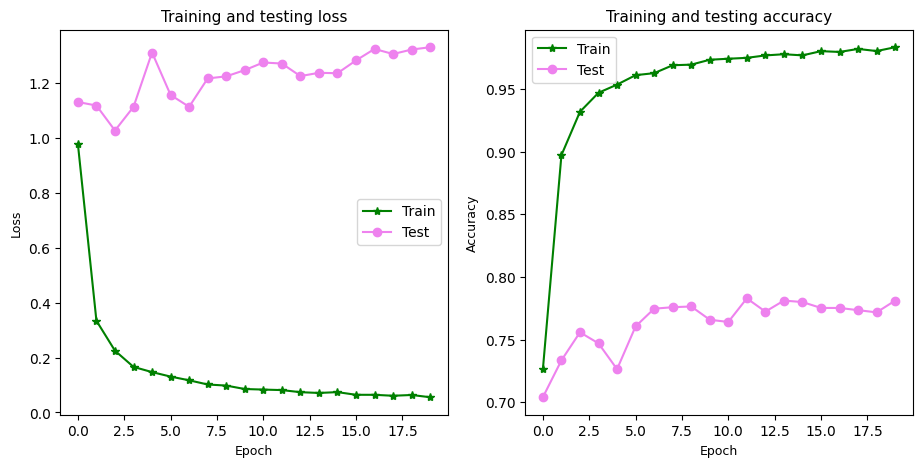

In [ ]:
model_v2_2, history = train(mobilenet_model_ft, batched_train_aug, batched_test)

Epoch 20 of 20 took 476 sec
  training loss (in-iteration): 	0.031
  test loss (in-iteration): 		1.790
  training accuracy: 			99.04%
  test accuracy: 			72.29%


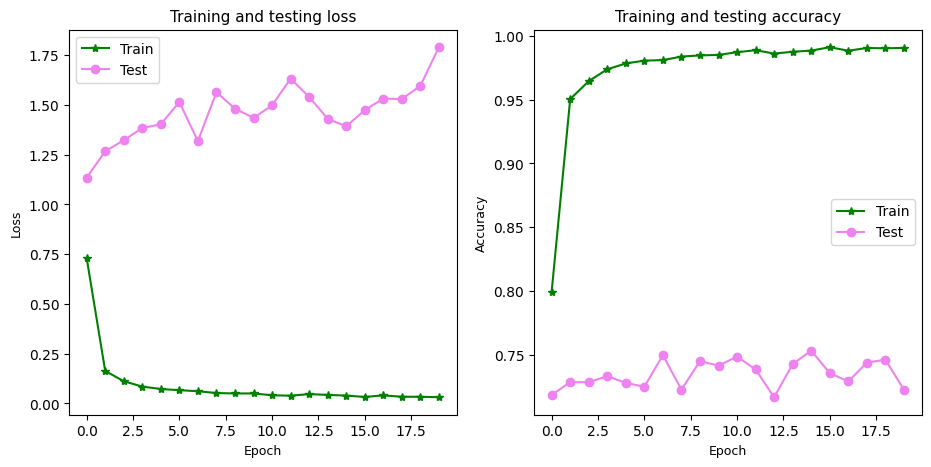

In [ ]:
model_v2_3, history = train(mobilenet_model_ft, batched_train, batched_test)

In [ ]:
torch.cuda.empty_cache()

🟡 Обучение модели mobilenet_v3 (fine tuning), на данных без изменений (только уменьшение размерности изображений для быстроты обучение) и на аугментированных данных.

In [ ]:
mobilenetv3_model_ft = nn.Sequential()
mobilenetv3_model_ft.add_module('mobilenetv3small', mobilenet_v3_small(weights='IMAGENET1K_V1'))

mobilenetv3_model_ft.add_module('relu_1', nn.ReLU())
mobilenetv3_model_ft.add_module('fc_1', nn.Linear(1000, 1024))
mobilenetv3_model_ft.add_module('relu_2', nn.ReLU())
mobilenetv3_model_ft.add_module('fc_2', nn.Linear(1024, 50))

mobilenetv3_model_ft = mobilenetv3_model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 78.0MB/s]


Epoch 20 of 20 took 529 sec
  training loss (in-iteration): 	0.020
  test loss (in-iteration): 		1.853
  training accuracy: 			99.38%
  test accuracy: 			72.18%


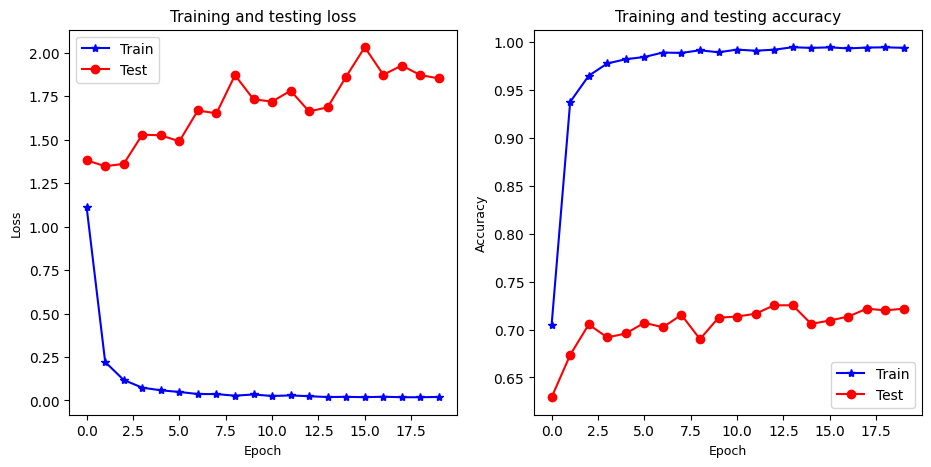

In [ ]:
model_v3, history = train(mobilenetv3_model_ft, batched_train, batched_test)

Epoch 20 of 20 took 527 sec
  training loss (in-iteration): 	0.032
  test loss (in-iteration): 		1.423
  training accuracy: 			98.92%
  test accuracy: 			75.76%


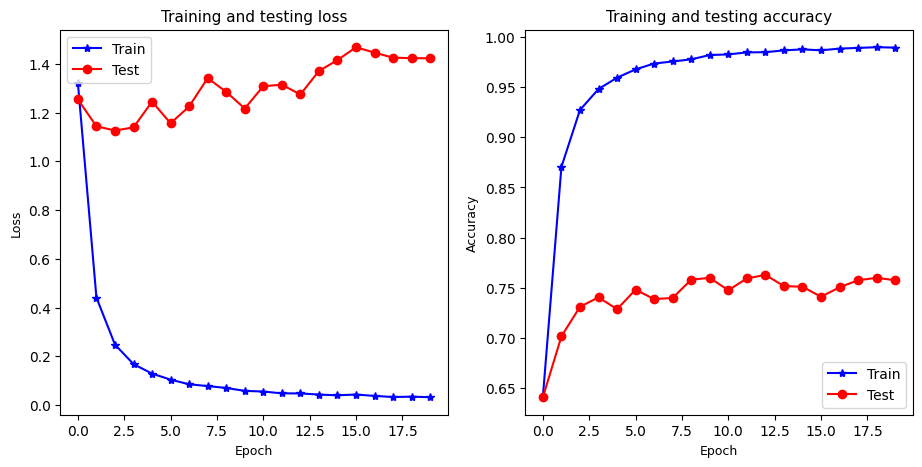

In [ ]:
model_v3_2, history = train(mobilenetv3_model_ft, batched_train_aug, batched_test)

In [ ]:
torch.cuda.empty_cache()

🟡 Обучение модели efficientnet_v2_small (fine tuning), на данных без изменений (только уменьшение размерности изображений для быстроты обучение) и на аугментированных данных.

In [ ]:
efficientnet_model_ft = nn.Sequential()
efficientnet_model_ft.add_module('efficientnet', efficientnet_v2_s(weights='IMAGENET1K_V1'))

efficientnet_model_ft.add_module('relu_1', nn.ReLU())
efficientnet_model_ft.add_module('fc_1', nn.Linear(1000, 1280))
efficientnet_model_ft.add_module('relu_2', nn.ReLU())
efficientnet_model_ft.add_module('fc_2', nn.Linear(1280, 50))

efficientnet_model_ft = efficientnet_model_ft.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 97.1MB/s]


Epoch 20 of 20 took 568 sec
  training loss (in-iteration): 	0.017
  test loss (in-iteration): 		1.305
  training accuracy: 			99.51%
  test accuracy: 			79.29%


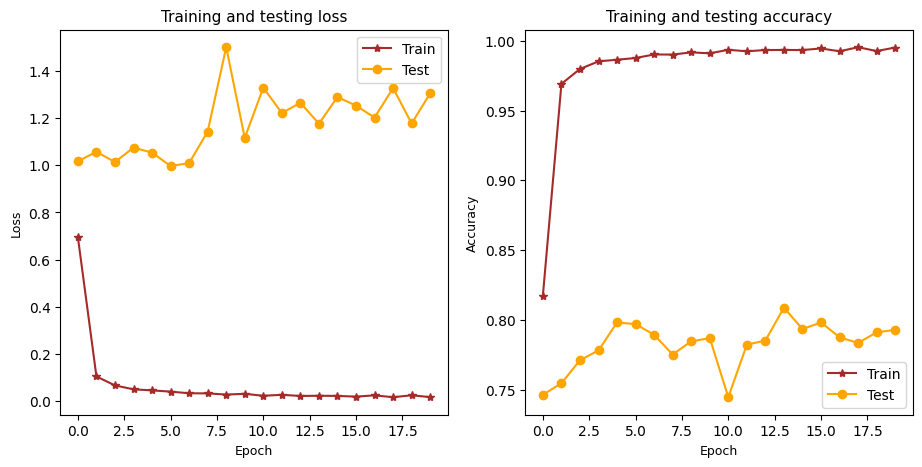

In [ ]:
model_efficient, history = train(efficientnet_model_ft, batched_train, batched_test)

Epoch 20 of 20 took 586 sec
  training loss (in-iteration): 	0.028
  test loss (in-iteration): 		1.016
  training accuracy: 			99.12%
  test accuracy: 			81.76%


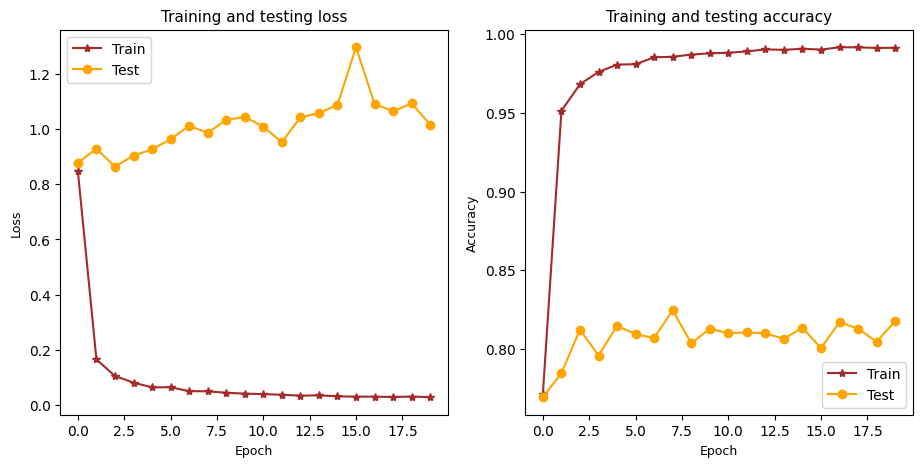

In [ ]:
model_efficient_2, history = train(efficientnet_model_ft, batched_train_aug, batched_test)

🔴 Результаты обучения моделей

In [ ]:
results = pd.DataFrame({'Потеря': [1.790, 1.329, 1.853, 1.423, 1.305, 1.016], 'Точность в %': [72.29, 78.12, 72.18, 75.76, 79.29, 81.76]},
                 index=['mobilenet_v2', 'mobilenet_v2_aug', 'mobilenet_v3_s', 'mobilenet_v3_s_aug', 'efficientnet_v2_s', 'efficientnet_v2_s_aug'])

In [ ]:
results

,Потеря,Точность в %
mobilenet_v2,1.790,72.29
mobilenet_v2_aug,1.329,78.12
mobilenet_v3_s,1.853,72.18
mobilenet_v3_s_aug,1.423,75.76
efficientnet_v2_s,1.305,79.29
efficientnet_v2_s_aug,1.016,81.76
